## Introduction

In this project, I will analyze the spread of the new corona virus. I will use this dataset:
    - The John Hopkins University's dataset which contains aggregated daily data for confirmed cases, deaths and recovered patients. 
    https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

## Create a function to transform all 3 datasets

In [4]:
def load(url, measure_name):
    df = pd.read_csv(url, index_col=[0, 1, 2, 3])
    df = df.stack()
    df = df.reset_index()

    cum = 'cum_' + measure_name
    df.columns = ['prov_state', 'country', 'lat', 'long', 'date', cum]

    df.date = pd.to_datetime(df.date, format='%m/%d/%y')

    df = df[df[cum] != 0]

    df['location'] = np.where(df.prov_state.isnull(), df.country, df.prov_state)

    if measure_name == 'case':
        df = error_correction(df)

    new = 'new_' + measure_name
    df[new] = df.groupby('location')[cum].diff(1)
    df[new] = df[new].fillna(df[cum])

    return df[['location', 'prov_state', 'country', 'lat', 'long', 'date', cum, new]]  # rearrange the columns and return the df


def error_correction(df):
    df.loc[(df.location == 'Japan') & (df.date == '2020-03-12'), 'cum_case'] = 675
    df.loc[(df.location == 'Italy') & (df.date == '2020-03-12'), 'cum_case'] = 15113
    df.loc[(df.location == 'Spain') & (df.date == '2020-03-12'), 'cum_case'] = 2965
    df.loc[(df.location == 'Switzerland') & (df.date == '2020-03-12'), 'cum_case'] = 858
    df.loc[(df.location == 'Netherlands') & (df.date == '2020-03-12'), 'cum_case'] = 614
    df.loc[(df.location == 'France') & (df.date == '2020-03-12'), 'cum_case'] = 2860

    return df

In [6]:
case = load(url_case, 'case')
death = load(url_death, 'death')
cured = load(url_cured, 'cured')

In [7]:
case.shape

(6167, 8)

In [8]:
death.shape

(1778, 8)

In [9]:
cured.shape

(3106, 8)

In [10]:
# Merge into 1 dataframe.
df = pd.merge(case, death, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])
df = pd.merge(df, cured, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])

In [11]:
df = df.set_index('date')

In [13]:
df = df.replace({'Martinique':'France', 
                       'Reunion':'France', 
                       'French Guiana':'France',
                       'Guadeloupe': 'France',
                       'Mayotte': 'France',
                       'Aruba': 'Netherlands',
                       'Curacao': 'Netherlands',
                       'Guernsey':'United Kingdom', 
                       'Jersey':'United Kingdom',
                       'Guam': 'US'})

In [14]:
df.head()

,location,prov_state,country,lat,long,cum_case,new_case,cum_death,new_death,cum_cured,new_cured
date,,,,,,,,,,,
2020-01-22,Thailand,NaN,Thailand,15.0,101.0,2,2.0,NaN,NaN,NaN,NaN
2020-01-23,Thailand,NaN,Thailand,15.0,101.0,3,1.0,NaN,NaN,NaN,NaN
2020-01-24,Thailand,NaN,Thailand,15.0,101.0,5,2.0,NaN,NaN,NaN,NaN
2020-01-25,Thailand,NaN,Thailand,15.0,101.0,7,2.0,NaN,NaN,NaN,NaN
2020-01-26,Thailand,NaN,Thailand,15.0,101.0,8,1.0,NaN,NaN,2.0,2.0


## Analysis

#### Cumulative cases in China

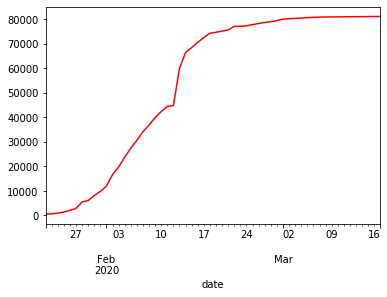

In [16]:
df[df.country == 'China'].groupby('date').sum().cum_case.plot(kind='line', c='r')

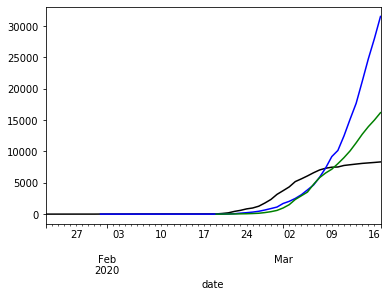

In [17]:
df[df.country == 'Korea, South'].groupby('date').sum().cum_case.plot(kind='line', c='black')
df[df.country == 'Italy'].groupby('date').sum().cum_case.plot(kind='line', c='blue')
df[df.country == 'Iran'].groupby('date').sum().cum_case.plot(kind='line', c='green')

#### New cases by selected countries

In [18]:
df_last_2_weeks = df.sort_index().last('2W')

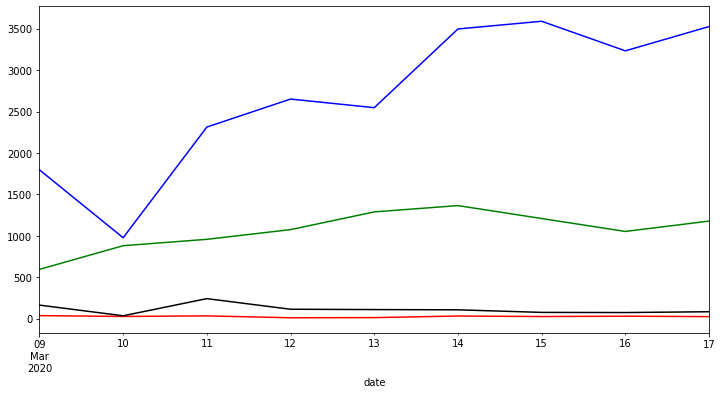

In [19]:
plt.figure(figsize=(12,6))
china = df_last_2_weeks[df_last_2_weeks.country == 'China'].resample('D').sum().new_case.plot(kind='line', color='red')
korea = df_last_2_weeks[df_last_2_weeks.country == 'Korea, South'].resample('D').sum().new_case.plot(kind='line', color='black')
italy = df_last_2_weeks[df_last_2_weeks.country == 'Italy'].resample('D').sum().new_case.plot(kind='line', color='blue')
iran = df_last_2_weeks[df_last_2_weeks.country == 'Iran'].resample('D').sum().new_case.plot(kind='line', color='green')

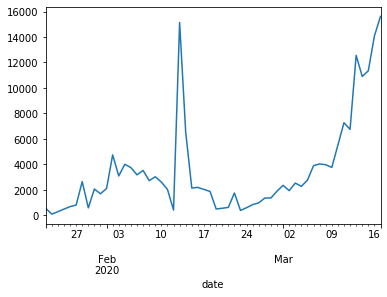

In [20]:
df.groupby('date').new_case.sum().plot(kind='line')

#### Number of new locations reporting first case, by date

In [21]:
first_case = df[df.cum_case.notnull()].reset_index().groupby(['location']).first()

In [22]:
first_case_by_date = first_case.date.value_counts()

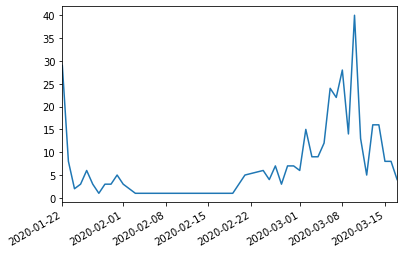

In [23]:
first_case_by_date.sort_index().plot(kind='line')

#### Number of new locations reporting death, by date

In [24]:
first_death = df[df.cum_death.notnull()].reset_index().groupby(['location']).first()

In [25]:
first_death_by_date = first_death.date.value_counts()

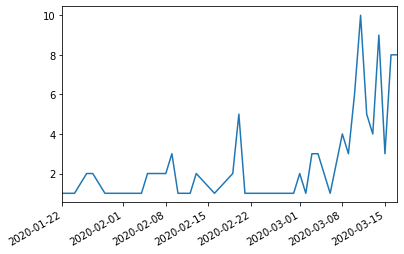

In [26]:
first_death_by_date.sort_index().plot(kind='line')

#### Playing with datetime index

In [27]:
df['day_name'] = df.index.day_name()

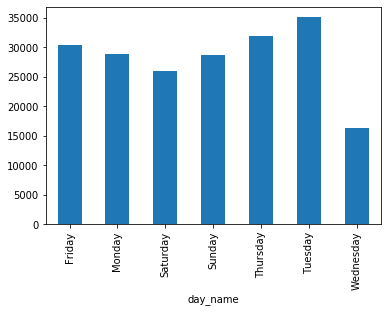

In [28]:
df.groupby('day_name').sum().new_case.plot(kind='bar')

In [29]:
# Weekly new cases
df.resample('W').sum().new_case

date
2020-01-26     2118.0
2020-02-02    14669.0
2020-02-09    23316.0
2020-02-16    31074.0
2020-02-23     7741.0
2020-03-01     9412.0
2020-03-08    21427.0
2020-03-15    58115.0
2020-03-22    29697.0
Freq: W-SUN, Name: new_case, dtype: float64

In [31]:
# Weekly new cases, excluding China
df[df.country != 'China'].resample('W').sum().new_case

date
2020-01-26       43.0
2020-02-02      114.0
2020-02-09      117.0
2020-02-16      390.0
2020-02-23     1232.0
2020-03-01     6502.0
2020-03-08    20536.0
2020-03-15    57935.0
2020-03-22    29642.0
Freq: W-SUN, Name: new_case, dtype: float64

In [32]:
gbdate = df.groupby('date').sum()

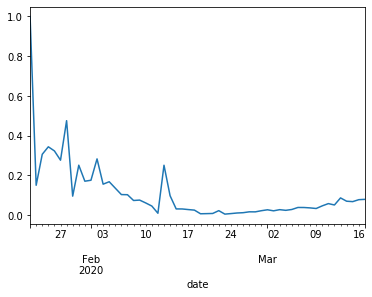

In [33]:
(gbdate.new_case/gbdate.cum_case).plot()